In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import plot_model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized


In [3]:
df = pd.read_csv("full_df_diabetic2_aug.csv")
df.head(3)

,Unnamed: 0,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,...,target,filename,normal,diabetic,glaucoma,cataract,macular degeneration,hypertensive,myopia,other
0,0,0,69,Female,0_left.jpg,0_right.jpg,['cataract'],['normal fundus'],0,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0,0,0,0,0,0,0
1,1,1,57,Male,1_left.jpg,1_right.jpg,['normal fundus'],['normal fundus'],1,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,1,0,0,0,0,0,0,0
2,2,2,42,Male,2_left.jpg,2_right.jpg,"['laser spot', 'moderate non diabetic retinopa...",['moderate non diabetic retinopathy'],0,1,...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,1,0,0,0,0,0,0


In [4]:
df


,Unnamed: 0,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,...,target,filename,normal,diabetic,glaucoma,cataract,macular degeneration,hypertensive,myopia,other
0,0,0,69,Female,0_left.jpg,0_right.jpg,['cataract'],['normal fundus'],0,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0,0,0,0,0,0,0
1,1,1,57,Male,1_left.jpg,1_right.jpg,['normal fundus'],['normal fundus'],1,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,1,0,0,0,0,0,0,0
2,2,2,42,Male,2_left.jpg,2_right.jpg,"['laser spot', 'moderate non diabetic retinopa...",['moderate non diabetic retinopathy'],0,1,...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,1,0,0,0,0,0,0
3,3,4,53,Male,4_left.jpg,4_right.jpg,['macular epiretinal membrane'],['mild non diabetic retinopathy'],0,1,...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,0,1,0,0,0,0,0,0
4,4,5,50,Female,5_left.jpg,5_right.jpg,['moderate non diabetic retinopathy'],['moderate non diabetic retinopathy'],0,1,...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24345,24345,22454,55,Female,3402_left.jpg,3402_right.jpg,"['lens dust', 'lens dust']","['lens dust', 'normal fundus']",1,0,...,NaN,3402_left_other2_22454.jpg,0,0,0,0,0,0,0,1
24346,24346,22455,55,Female,3402_left.jpg,3402_right.jpg,"['lens dust', 'lens dust']","['lens dust', 'normal fundus']",1,0,...,NaN,3402_left_other3_22455.jpg,0,0,0,0,0,0,0,1
24347,24347,22456,55,Male,4149_left.jpg,4149_right.jpg,['low image quality'],['low image quality'],1,0,...,NaN,4149_left_other1_22456.jpg,0,0,0,0,0,0,0,1
24348,24348,22457,55,Male,4149_left.jpg,4149_right.jpg,['low image quality'],['low image quality'],1,0,...,NaN,4149_left_other2_22457.jpg,0,0,0,0,0,0,0,1


In [5]:
df.glaucoma.value_counts()

glaucoma
0    20957
1     3393
Name: count, dtype: int64

In [6]:
glaucoma = df.loc[(df.glaucoma ==1)]["filename"].values
glaucoma[:15]

array(['43_right.jpg', '167_right.jpg', '238_right.jpg', '247_right.jpg',
       '365_right.jpg', '583_right.jpg', '746_right.jpg', '931_right.jpg',
       '1209_right.jpg', '1210_right.jpg', '1211_right.jpg',
       '1212_right.jpg', '1213_right.jpg', '1214_right.jpg',
       '1215_right.jpg'], dtype=object)

In [7]:
print("Number of images in glaucoma: {}".format(len(glaucoma)))

Number of images in glaucoma: 3393


In [8]:
df.shape

(24350, 28)

In [9]:
df.normal.value_counts()

normal
0    21335
1     3015
Name: count, dtype: int64

In [10]:
normal = df.loc[(df.normal ==1)]["filename"].values
normal[:15]

array(['0_right.jpg', '1_right.jpg', '8_right.jpg', '10_right.jpg',
       '29_right.jpg', '31_right.jpg', '35_right.jpg', '37_right.jpg',
       '38_right.jpg', '47_right.jpg', '49_right.jpg', '61_right.jpg',
       '65_right.jpg', '66_right.jpg', '73_right.jpg'], dtype=object)

In [11]:
print("Number of images in normal: {}".format(len(normal)))

Number of images in normal: 3015


In [12]:
print(len(glaucoma),len(normal))

3393 3015


In [13]:
# Balance the dataset
min_size = min(len(glaucoma), len(normal))
glaucoma = np.random.choice(glaucoma, min_size, replace=False)
normal = np.random.choice(normal, min_size, replace=False)

In [14]:
print(len(glaucoma),len(normal))

3015 3015


In [13]:
dataset_dir = "Training Images/"
image_size=224
#labels = []
def create_dataset(image_category, label):
    dataset = []
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [14]:
dataset = []
dataset += create_dataset(glaucoma,1)
dataset += create_dataset(normal,0)

100%|██████████| 3015/3015 [01:20<00:00, 37.60it/s]


In [15]:
len(dataset)

6408

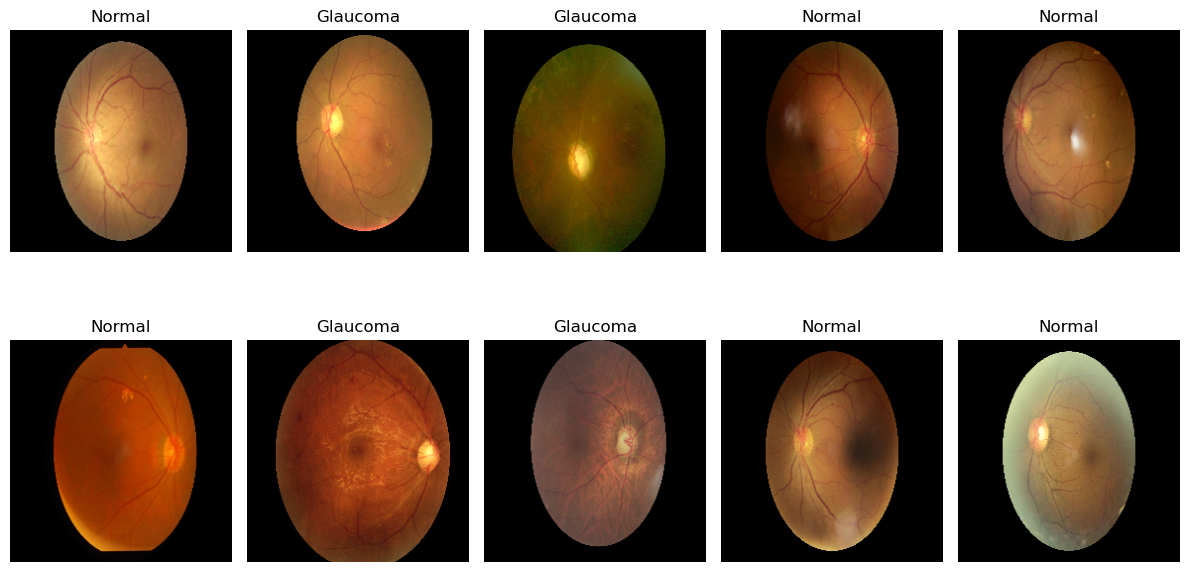

In [16]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
    plt.subplot(2,5,i+1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
plt.tight_layout()    

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [18]:
print(x.shape)
print(y.shape)

(6408, 224, 224, 3)
(6408,)


In [19]:
# Get the Barchat
gt_t = []
for g in y:
    if g == 0:
        gt_t.append("Normal")
    else:
        gt_t.append("Glaucoma")
        
gt_t = np.array(gt_t)
gt_t.shape

(6408,)

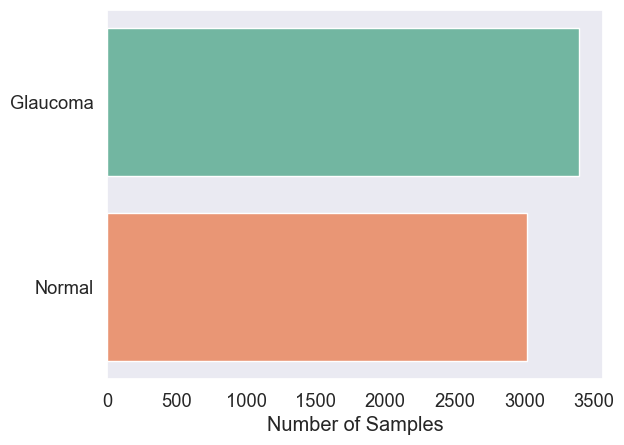

In [20]:
sns.set(style="dark", font_scale=1.2)
ax = sns.countplot(y=gt_t, palette="Set2")

ax.set(xlabel='Number of Samples')
plt.grid(False)
plt.show()

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [22]:
print(f'x_train',x_train.shape)
print(f'x_test',x_test.shape)
print(f'y_train',y_train.shape)
print(f'y_test',y_test.shape)

x_train (5126, 224, 224, 3)
x_test (1282, 224, 224, 3)
y_train (5126,)
y_test (1282,)


In [26]:
'''train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    #rescale=1./255
)

In [27]:
'''batch_size=32
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [30]:
'''train_steps = math.ceil(len(x_train) / batch_size)
val_steps = math.ceil(len(x_test) / batch_size)

In [23]:
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [27]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy", Precision(), Recall()])

In [28]:
checkpoint = ModelCheckpoint("vgg19_glaucoma_full_df_aug1.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy",patience=20,verbose=1)

In [29]:
history = model.fit(x_train,y_train,batch_size=32,epochs=40,validation_data=(x_test,y_test),
                   verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/40
161/161 [==============================] - ETA: 0s - loss: 1.2143 - accuracy: 0.8135 - precision: 0.8246 - recall: 0.8209
Epoch 1: val_accuracy improved from -inf to 0.88534, saving model to vgg19_glaucoma_full_df_aug1.h5
161/161 [==============================] - 30s 156ms/step - loss: 1.2143 - accuracy: 0.8135 - precision: 0.8246 - recall: 0.8209 - val_loss: 0.6288 - val_accuracy: 0.8853 - val_precision: 0.8766 - val_recall: 0.9159
Epoch 2/40
160/161 [============================>.] - ETA: 0s - loss: 0.3673 - accuracy: 0.9223 - precision: 0.9260 - recall: 0.9267
Epoch 2: val_accuracy improved from 0.88534 to 0.88846, saving model to vgg19_glaucoma_full_df_aug1.h5
161/161 [==============================] - 23s 142ms/step - loss: 0.3693 - accuracy: 0.9220 - precision: 0.9254 - recall: 0.9267 - val_loss: 0.6943 - val_accuracy: 0.8885 - val_precision: 0.9348 - val_recall: 0.8522
Epoch 3/40
160/161 [============================>.] - ETA: 0s - loss: 0.6129 - accuracy: 0.9115 - p

In [30]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

41/41 [==============================] - 4s 108ms/step - loss: 1.0637 - accuracy: 0.9462 - precision: 0.9481 - recall: 0.9522


ValueError: too many values to unpack (expected 2)

In [31]:
# Use the predict method to get the predicted probabilities
y_pred_probabilities = model.predict(x_test)

# Convert probabilities to class labels
#y_pred = np.argmax(y_pred_probabilities, axis=1)
y_pred = (y_pred_probabilities > 0.5).astype(int)


41/41 [==============================] - 4s 108ms/step


In [32]:
accuracy_score(y_test,y_pred)

0.9461778471138845

In [33]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       592
           1       0.95      0.95      0.95       690

    accuracy                           0.95      1282
   macro avg       0.95      0.95      0.95      1282
weighted avg       0.95      0.95      0.95      1282



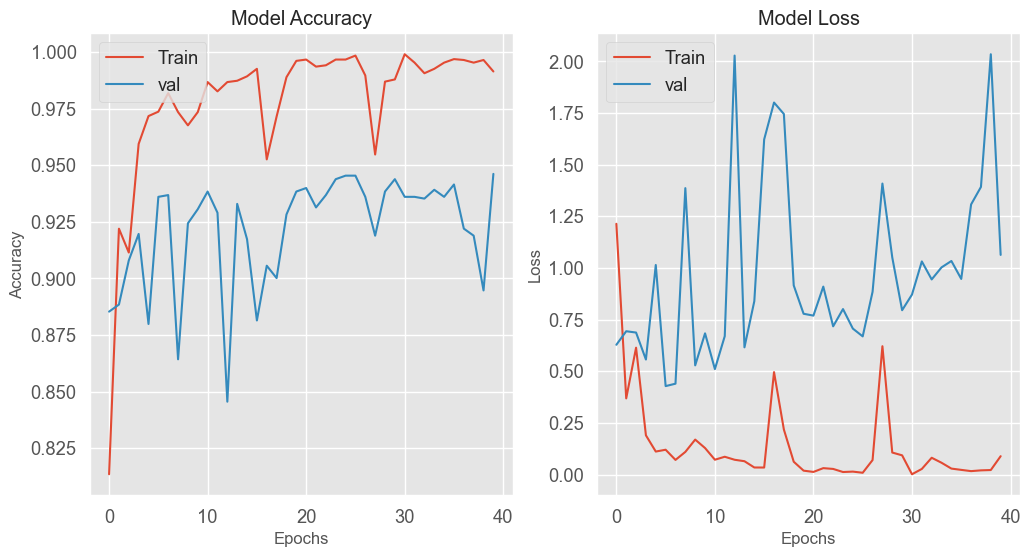

In [34]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

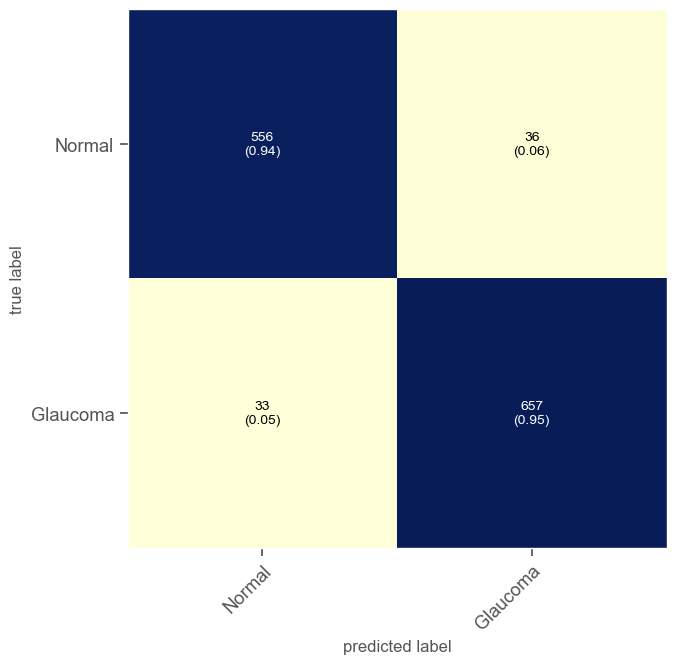

In [35]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Glaucoma"],
                      show_normed = True, cmap ='YlGnBu');

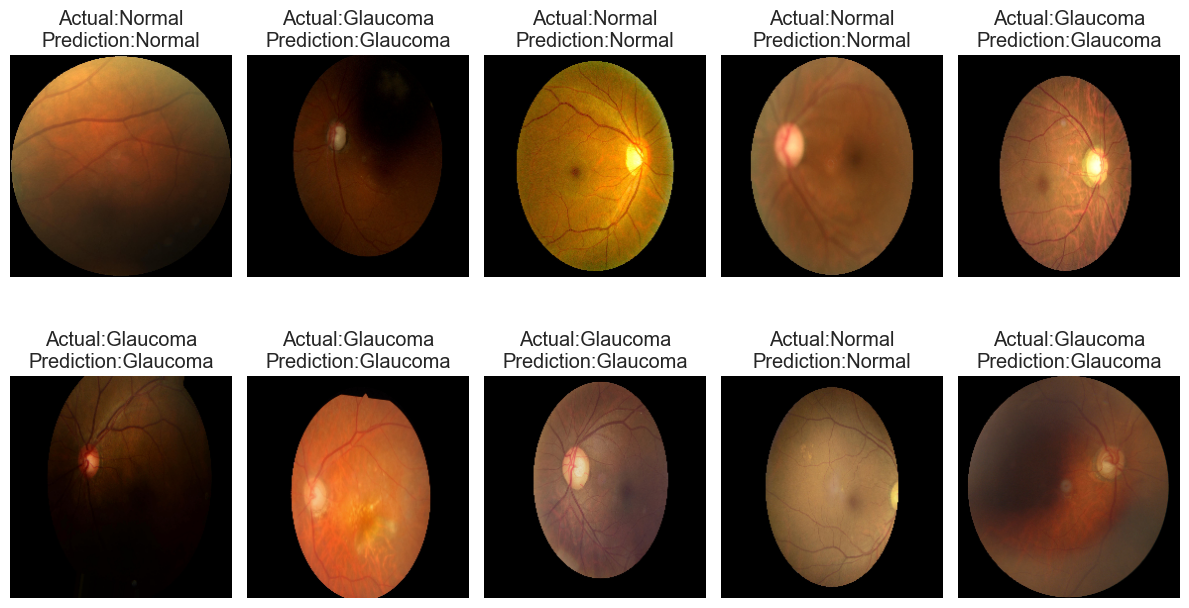

In [36]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"
        
    plt.subplot(2,5,i+1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

In [37]:
# Directory containing the testing images
testing_dir = 'Testing Images'

In [38]:
# Function to load and preprocess images
def load_testing_images(directory, image_size):
    images = []
    filenames = []
    for img_filename in os.listdir(directory):
        img_path = os.path.join(directory, img_filename)
        try:
            # Read and resize image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (image_size, image_size))

            # Convert to array and normalize
            img_array = np.array(img) / 255.0
            images.append(img_array)
            filenames.append(img_filename)
        except Exception as e:
            print(f"Error loading image {img_filename}: {e}")
    return np.array(images), filenames

In [39]:
# Load testing images
test_images, test_filenames = load_testing_images(testing_dir, image_size)

In [40]:
# Check if images are loaded correctly
print(f'Loaded {len(test_images)} images for testing')

Loaded 1000 images for testing


In [41]:
# Predict using the model
predictions = model.predict(test_images,batch_size=16)
predicted_categories = (predictions > 0.5).astype(int)

63/63 [==============================] - 7s 81ms/step


In [42]:
# Visualize some test images with their predicted labels

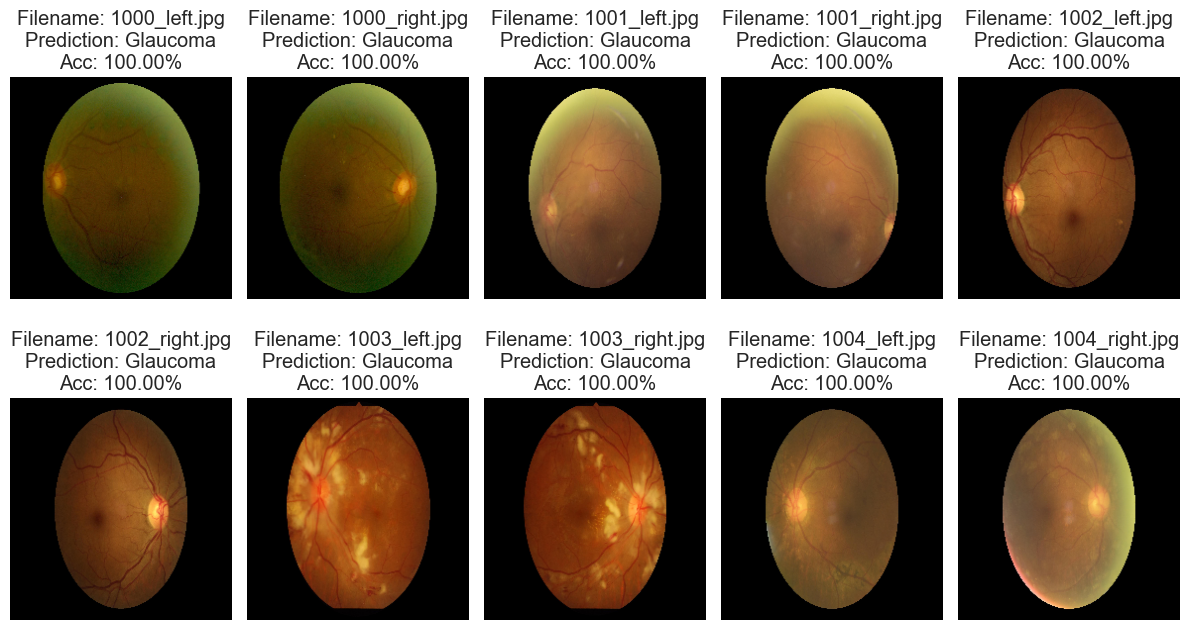

In [43]:
plt.figure(figsize=(12, 7))
for i in range(min(10, len(test_images))):
    plt.subplot(2, 5, i+1)
    
    if test_images[i].dtype != np.uint8:
        image = (test_images[i] * 255).astype(np.uint8)
    else:
        image = test_images[i]
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    pred_label = "Glaucoma" if predicted_categories[i] == 1 else "Normal"
    plt.title(f"Filename: {test_filenames[i]}\nPrediction: {pred_label}\nAcc: {predictions[i][0]*100:.2f}%")
plt.tight_layout()
plt.show()

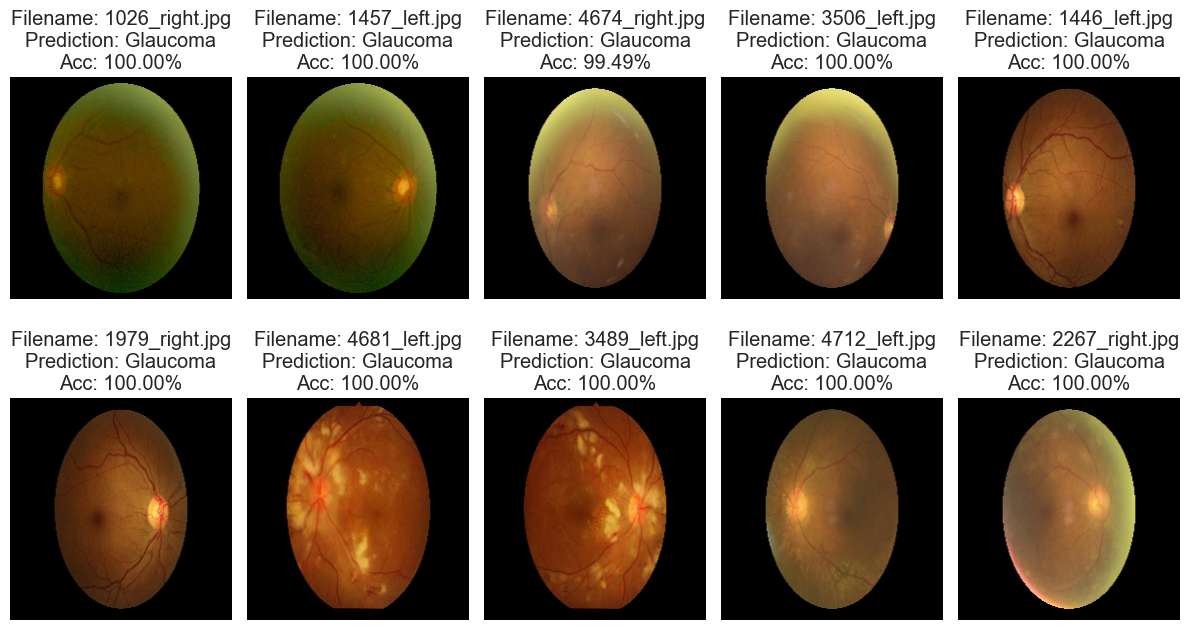

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images you want to display
num_images_to_display = min(10, len(test_images))

# Generate random indices
random_indices = np.random.choice(len(test_images), num_images_to_display, replace=False)

# Plotting the images
plt.figure(figsize=(12, 7))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)

    if test_images[i].dtype != np.uint8:
        image = (test_images[i] * 255).astype(np.uint8)
    else:
        image = test_images[i]
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    pred_label = "Glaucoma" if predicted_categories[idx] == 1 else "Normal"
    plt.title(f"Filename: {test_filenames[idx]}\nPrediction: {pred_label}\nAcc: {predictions[idx][0]*100:.2f}%")
plt.tight_layout()
plt.show()


**END**